In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OrdinalEncoder,StandardScaler,OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,accuracy_score,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline as ImblearnPipeline
from sklearn.model_selection import GridSearchCV

## About the DataSet
#### Our hospital has patient information and needs an estimation of exactly which variables affect whether people will be stroked or not.
 
- The goal is:
    - Which variables are significant in predicting whether patient will have strokes or not.
    - How well do those variables describe whether patient will have strokes or not

In [3]:
file_path = "full_data.csv"

data = pd.read_csv(file_path)


#### Exploring the Dataset

In [4]:
data.head(10)


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
2,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
3,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
4,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
5,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
6,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
7,Female,78.0,0,0,Yes,Private,Urban,58.57,24.2,Unknown,1
8,Female,81.0,1,0,Yes,Private,Rural,80.43,29.7,never smoked,1
9,Female,61.0,0,1,Yes,Govt_job,Rural,120.46,36.8,smokes,1


In [5]:
data.shape


(4981, 11)

In [6]:
data.describe()


,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000,4981.000000
mean,43.419859,0.096165,0.055210,105.943562,28.498173,0.049789
std,22.662755,0.294848,0.228412,45.075373,6.790464,0.217531
min,0.080000,0.000000,0.000000,55.120000,14.000000,0.000000
25%,25.000000,0.000000,0.000000,77.230000,23.700000,0.000000
50%,45.000000,0.000000,0.000000,91.850000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,113.860000,32.600000,0.000000
max,82.000000,1.000000,1.000000,271.740000,48.900000,1.000000


In [7]:
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4981 entries, 0 to 4980
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             4981 non-null   object 
 1   age                4981 non-null   float64
 2   hypertension       4981 non-null   int64  
 3   heart_disease      4981 non-null   int64  
 4   ever_married       4981 non-null   object 
 5   work_type          4981 non-null   object 
 6   Residence_type     4981 non-null   object 
 7   avg_glucose_level  4981 non-null   float64
 8   bmi                4981 non-null   float64
 9   smoking_status     4981 non-null   object 
 10  stroke             4981 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 428.2+ KB


In [8]:
data[data.duplicated()]


,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke


#### There are no null or duplicated data points.

## Target Variable 'stroke'

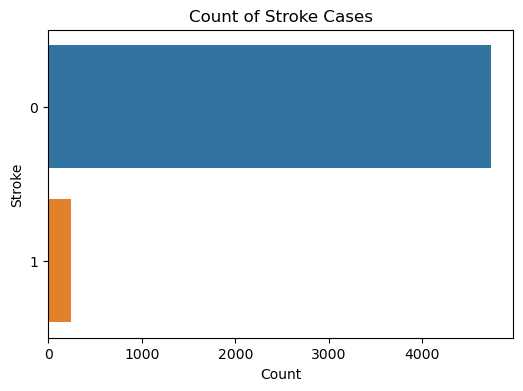

In [9]:
plt.figure(figsize=(6, 4))
sns.countplot(data=data, y='stroke')

plt.title("Count of Stroke Cases")
plt.xlabel("Count")
plt.ylabel("Stroke")
plt.show()


#### We can observe that:
- We have highly imbalance data in the target of stroke.

#### Solution:
- We can use RandomOverSampler to solve this problem.However, it just doesn't have any new samples and is just a duplicate. On top of that, it will balance until it reaches the highest sample of the other sample. In this case, we will use SMOTENC in order to balance the data, which will fix all the problems RandomOverSampler encounters.




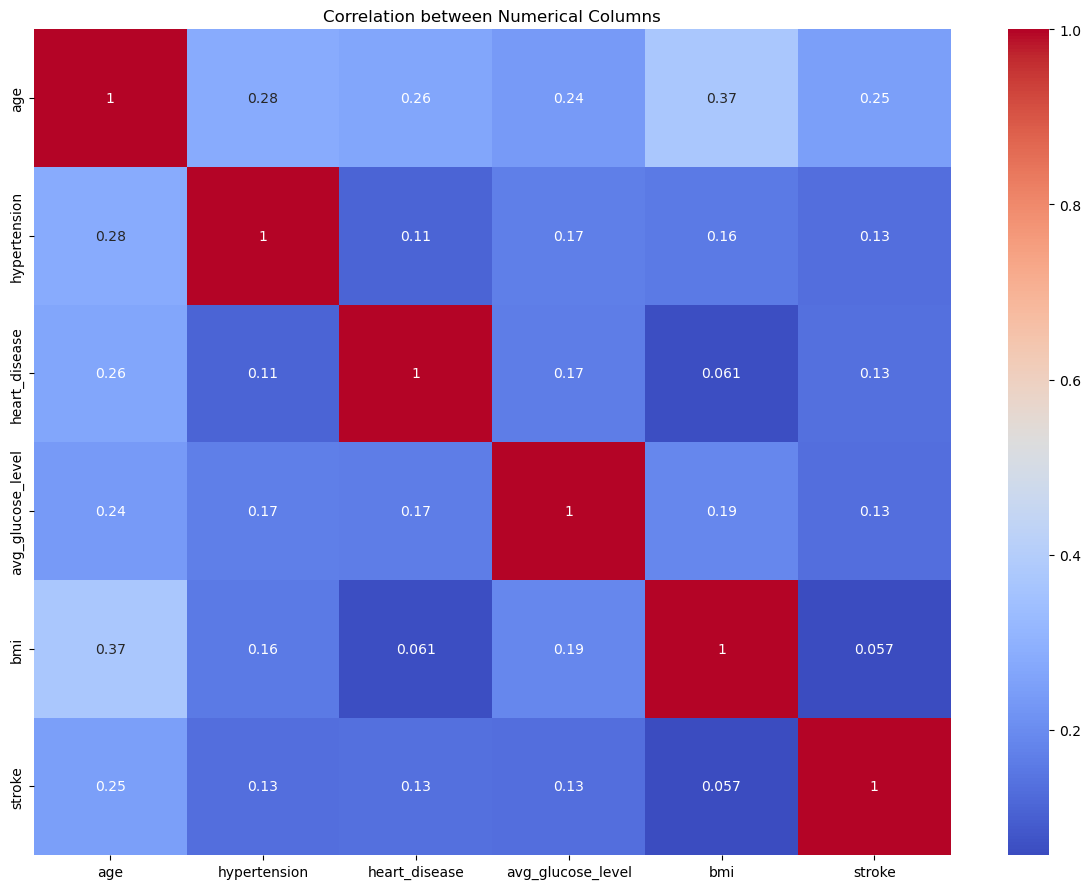

In [10]:
#Exclude non-numeric columns
numeric_data = data.select_dtypes(include=[np.number])

plt.figure(figsize=(12, 9))
corr_mat = numeric_data.corr()
sns.heatmap(corr_mat, annot=True, cmap='coolwarm')

plt.title("Correlation between Numerical Columns")
plt.tight_layout()
plt.show()

#### We can observe that:
- In numerical features, there is no strong correlation between features and target. In addition, we see that the target-to-target correlation is low, which is beneficial and helps to avoid overfitting in the future.

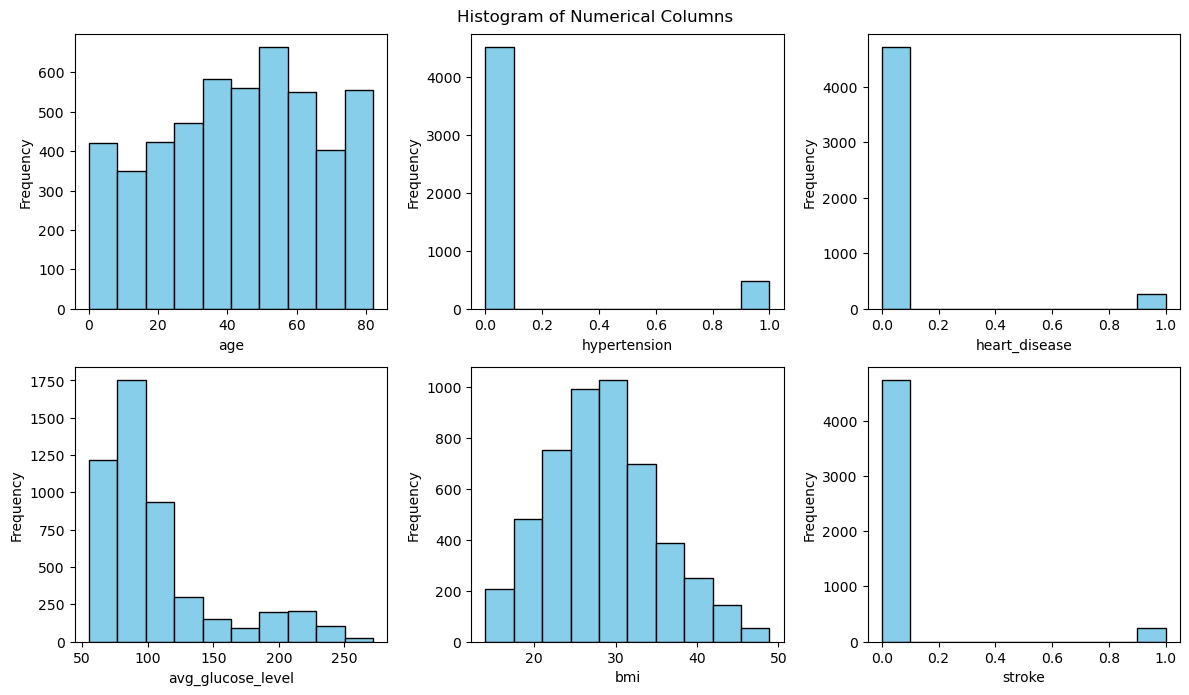

In [11]:
# Determine the number of rows and columns for subplot grid
num_features = len(numeric_data.columns)
num_rows = int(np.ceil(num_features / 2))
num_cols = 3

# Create subplots
plt.figure(figsize=(12, 10))

# Iterate over numeric columns and create histograms
for i, column in enumerate(numeric_data.columns, start=1):
    plt.subplot(num_rows, num_cols, i)
    plt.hist(data[column], color='skyblue', edgecolor='black')
    plt.xlabel(column)
    plt.ylabel("Frequency")

# Adjust layout and show plot
plt.suptitle("Histogram of Numerical Columns")
plt.tight_layout()
plt.show()


- We are using histogram in this case in order to easier point out the outliers. As we can see from the chart above, their is no outlier in this dataset

### Exploring Categorical Variables

In [12]:
cat_cols = data.select_dtypes(include=['object']).columns
cat_cols

Index(['gender', 'ever_married', 'work_type', 'Residence_type',
       'smoking_status'],
      dtype='object')

In [13]:
for i, col in enumerate(cat_cols):
    print(f'{col.title()}: {data[col].unique()}')

Gender: ['Male' 'Female']
Ever_Married: ['Yes' 'No']
Work_Type: ['Private' 'Self-employed' 'Govt_job' 'children']
Residence_Type: ['Urban' 'Rural']
Smoking_Status: ['formerly smoked' 'never smoked' 'smokes' 'Unknown']


#### Ploting categorical features to see number of categories in that features

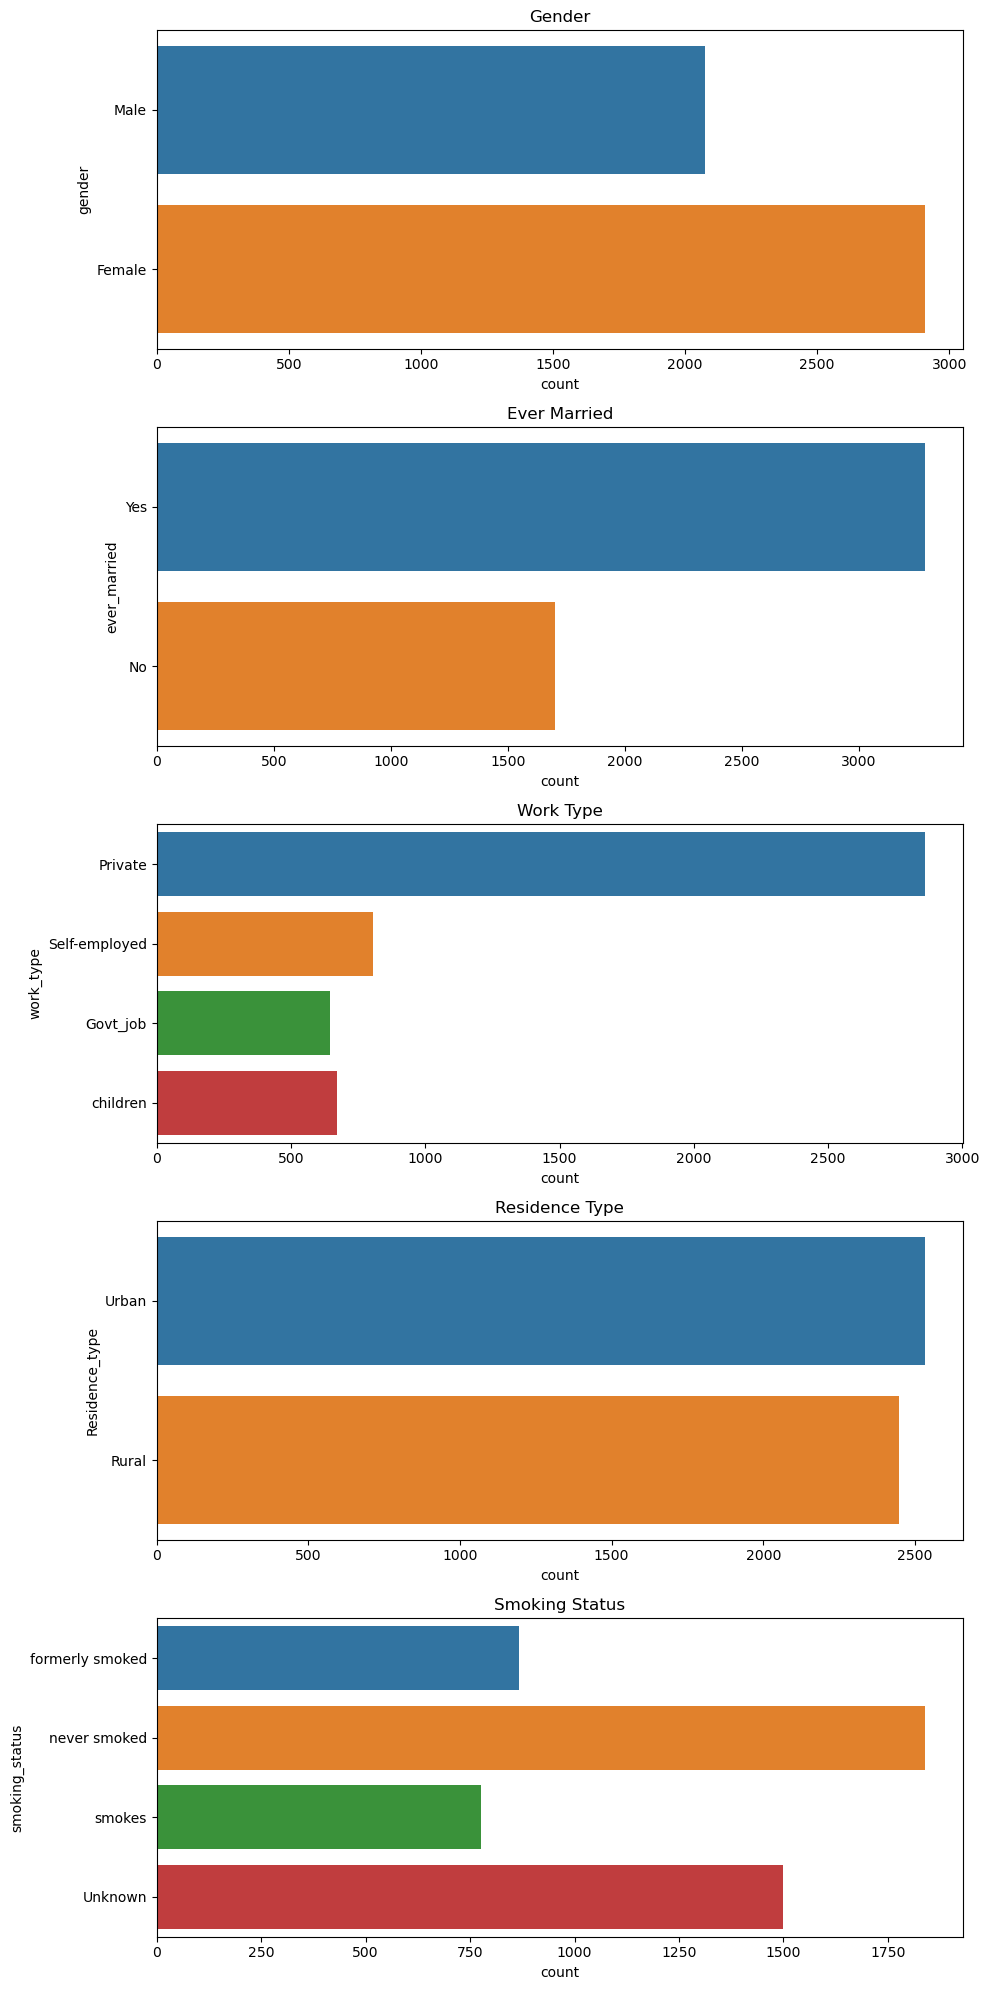

In [14]:
# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(10, 20))

# Plot for Gender
sns.countplot(y='gender', data=data, ax=axes[0])
axes[0].set_title('Gender')

# Plot for Ever_Married
sns.countplot(y='ever_married', data=data, ax=axes[1])
axes[1].set_title('Ever Married')

# Plot for Work_Type
sns.countplot(y='work_type', data=data, ax=axes[2])
axes[2].set_title('Work Type')

# Plot for Residence_Type
sns.countplot(y='Residence_type', data=data, ax=axes[3])
axes[3].set_title('Residence Type')

# Plot for Smoking_Status
sns.countplot(y='smoking_status', data=data, ax=axes[4])
axes[4].set_title('Smoking Status')

plt.tight_layout()
plt.show()


## Building a Classification Model

In [15]:
target = "stroke"
# input features
x = data.drop([target,"gender"],axis=1)

# target variable
y = data[target]

In [16]:
x_train,x_test,y_train,y_test = train_test_split(x,y,test_size=0.2,random_state=2024)

print("X_train shape: ",x_train.shape)
print("X_test shape: ", x_test.shape)
print("y_train shape: ", y_train.shape)
print("y_test shape: ", x_test.shape)

X_train shape:  (3984, 9)
X_test shape:  (997, 9)
y_train shape:  (3984,)
y_test shape:  (997, 9)


#### Preprocessing categorical feartures

In [17]:
nom_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("scaler",OneHotEncoder())
])

#### Preprocessing numerical and boolean feartures

In [18]:
ever_married_values = x_train["ever_married"].unique()
residence_type_values = x_train["Residence_type"].unique()
smoking_status_values = ["smokes","formerly smoked", "Unknown","never smoked"]


ord_transformer = Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("ord",OrdinalEncoder(categories=[ever_married_values,residence_type_values,smoking_status_values]))
])

num_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",StandardScaler())
])

#### Fit model and Predicting

In [19]:
preprocessor = ColumnTransformer(transformers=[
    ("ord_feartures",ord_transformer,["ever_married","Residence_type","smoking_status"]),
    ("num_features",num_transformer,["age","hypertension","heart_disease","avg_glucose_level","bmi"]),
    ("nom_features",nom_transformer,["work_type"])
])

clf = Pipeline(steps=[
    ("preprocessor",preprocessor),
    ("model",RandomForestClassifier(random_state=2024))
])

clf.fit(x_train,y_train)
y_predict = clf.predict(x_test)

# Create a DataFrame to store predicted and actual values
result_df = pd.DataFrame({"Predicted": y_predict, "Actual": y_test})

# Display the DataFrame
display(result_df)

,Predicted,Actual
2944,0,0
4467,0,0
3206,0,0
4754,0,0
4097,0,0
...,...,...
798,0,0
1032,0,0
2053,0,0
4040,0,0


#### Evaluate performance (before balanced data)

In [20]:
print("Accuracy: ",accuracy_score(y_test,y_predict))
print("Classification report:\n",classification_report(y_test,y_predict))
print("Confusion matrix:\n",confusion_matrix(y_test,y_predict))

Accuracy:  0.9438314944834504
Classification report:
               precision    recall  f1-score   support

           0       0.95      1.00      0.97       942
           1       0.33      0.02      0.03        55

    accuracy                           0.94       997
   macro avg       0.64      0.51      0.50       997
weighted avg       0.91      0.94      0.92       997

Confusion matrix:
 [[940   2]
 [ 54   1]]


## From the above performance metrics: 

#### We can conclude that our models have great performance. However,this is not actually true because we have imbalanced data in which patients who don't have strokes are the majority. In order to check if it is correct or not, we will use SMOTENC in order to balance the data and also use GridSearchCV to find the best hyperparameter.


In [21]:
#store categorical features into list
categorical_features = ['ever_married', 'Residence_type', 'work_type', 'smoking_status']

#create empty list to store the index of that feature
categorical_features_indices = []

#find index and append to new list
for feature_name in categorical_features:
    feature_index = x_train.columns.get_loc(feature_name)
    categorical_features_indices.append(feature_index)


balance_data = SMOTENC(categorical_features=categorical_features_indices,sampling_strategy={1:1800}, random_state=2024)
x_train_balanced, y_train_balanced = balance_data.fit_resample(x_train, y_train)

clf = ImblearnPipeline(steps=[
    ("preprocessor",preprocessor),
    ("oversampler", balance_data),
    ("model",RandomForestClassifier(random_state=2024))
])


#### Compare before and after balance data

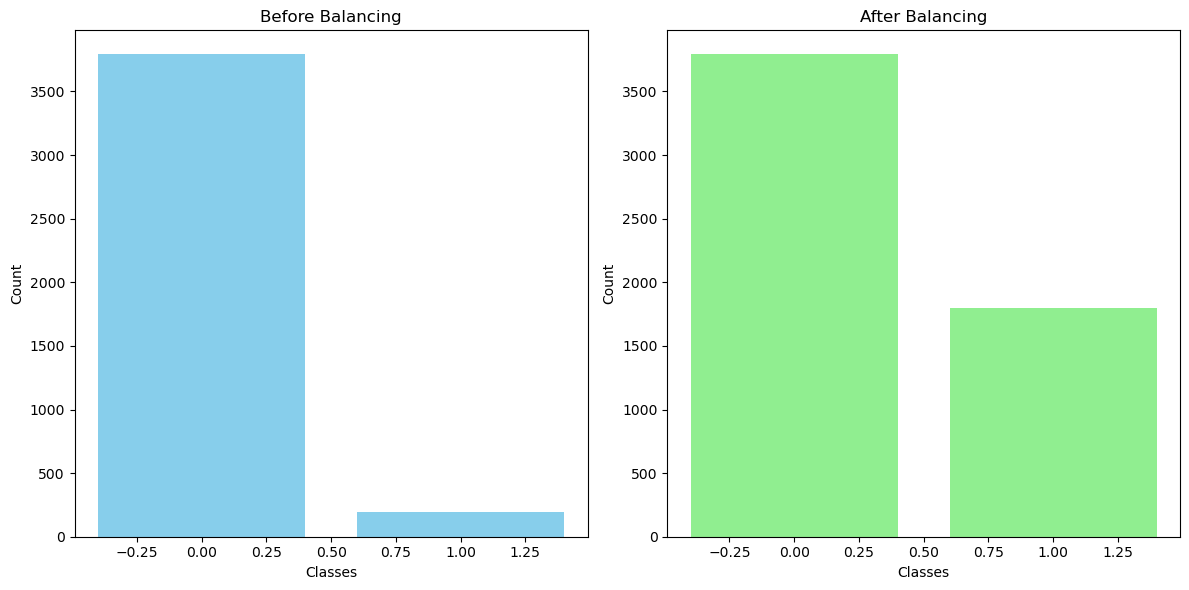

In [30]:
import matplotlib.pyplot as plt

# Define the classes and their respective counts before and after balancing
classes_before = y_train.value_counts(normalize=False)
classes_after = y_train_balanced.value_counts(normalize=False)

# Plotting before and after balancing
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.bar(classes_before.index, classes_before.values, color='skyblue')
plt.title('Before Balancing')
plt.xlabel('Classes')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
plt.bar(classes_after.index, classes_after.values, color='lightgreen')
plt.title('After Balancing')
plt.xlabel('Classes')
plt.ylabel('Count')

plt.tight_layout()
plt.show()



#### Evaluate performance (after balanced data)

In [35]:
clf.fit(x_train_balanced, y_train_balanced)
y_predict = clf.predict(x_test)

print("accuracy: ",accuracy_score(y_test,y_predict))
print(classification_report(y_test,y_predict))
print(confusion_matrix(y_test,y_predict))

accuracy:  0.9197592778335005
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       942
           1       0.25      0.24      0.25        55

    accuracy                           0.92       997
   macro avg       0.61      0.60      0.60       997
weighted avg       0.92      0.92      0.92       997

[[904  38]
 [ 42  13]]


## From the above performance metrics(After balance data): 

#### We can see that after balance data. It's have slight increase in our performance metric that is precision increase from 0.91 to 0.92 and also the true negative rate also increase. It depend on our hospital, if they want concentrate on specific performance such as precision, recall or f1. We will find the best model that have optimum performance metric in that field.

## Continue improve performance of model:

#### After balancing the data, there is also another way to enhance our data: finding the best parameter of that model using GridSearchCV or RandomizedSearchCV, which is very helpful to optimise our model and also compare it with other models to find the best one to deploy.


In [47]:
param_grid = {
    "model__criterion": ["gini", "entropy"],
    "model__n_estimators": [5,10,50,100,200],
    "model__max_features": ["sqrt", "log2",None],
    "model__class_weight": ["balanced", "balanced_subsample"],
}

grid_search = GridSearchCV(clf,param_grid=param_grid,cv=4,error_score='raise',verbose=1,n_jobs=-1)

grid_search.fit(x_train_balanced, y_train_balanced)

y_predict = grid_search.predict(x_test)
print(grid_search.best_params_)

Fitting 4 folds for each of 60 candidates, totalling 240 fits
{'model__class_weight': 'balanced_subsample', 'model__criterion': 'entropy', 'model__max_features': 'sqrt', 'model__n_estimators': 200}


## Fit best param into model in order to see the performance

In [46]:

clf = ImblearnPipeline(steps=[
    ("preprocessor",preprocessor),
    ("oversampler", balance_data),
    ("model",RandomForestClassifier(class_weight="balanced_subsample",criterion="entropy",max_features="sqrt",n_estimators=200,random_state=2024))
])

clf.fit(x_train_balanced, y_train_balanced)
y_predict = clf.predict(x_test)

print("accuracy: ",accuracy_score(y_test,y_predict))
print(classification_report(y_test,y_predict))
print(confusion_matrix(y_test,y_predict))

accuracy:  0.9137412236710131
              precision    recall  f1-score   support

           0       0.95      0.96      0.95       942
           1       0.20      0.18      0.19        55

    accuracy                           0.91       997
   macro avg       0.57      0.57      0.57       997
weighted avg       0.91      0.91      0.91       997

[[901  41]
 [ 45  10]]


#### Having said that:

- Though our performance has slightly decreased. So, we can considered choosing one of them to enhance our performance. We can still combine both and compare with other models.

# Implementing other models

### -SVC

In [48]:
from sklearn.svm import SVC

clf_svc = ImblearnPipeline(steps=[
    ("preprocessor",preprocessor),
    ("oversampler", balance_data),
    ("model",SVC(random_state=2024))
])

param_grid = {
    "model__gamma":["scale", "auto"],
    "model__kernel":["linear", "poly", "rbf", "sigmoid"],
    "model__decision_function_shape":["ovo", "ovr"],
    "model__class_weight": ["balanced", None]
}

grid_search_svc = GridSearchCV(clf_svc,param_grid=param_grid,cv=4,error_score='raise',verbose=1,n_jobs=-1)

grid_search_svc.fit(x_train_balanced, y_train_balanced)

y_predict = grid_search_svc.predict(x_test)
print(grid_search_svc.best_params_)

Fitting 4 folds for each of 32 candidates, totalling 128 fits
{'model__class_weight': None, 'model__decision_function_shape': 'ovo', 'model__gamma': 'scale', 'model__kernel': 'rbf'}


In [49]:
clf_svc = ImblearnPipeline(steps=[
    ("preprocessor",preprocessor),
    ("oversampler", balance_data),
    ("model",SVC(class_weight=None,decision_function_shape="ovo",gamma= "scale",kernel="rbf",random_state=2024))
])

clf_svc.fit(x_train_balanced, y_train_balanced)
y_predict = clf_svc.predict(x_test)

print("accuracy: ",accuracy_score(y_test,y_predict))
print(classification_report(y_test,y_predict))
print(confusion_matrix(y_test,y_predict))


accuracy:  0.847542627883651
              precision    recall  f1-score   support

           0       0.96      0.87      0.92       942
           1       0.16      0.42      0.23        55

    accuracy                           0.85       997
   macro avg       0.56      0.65      0.57       997
weighted avg       0.92      0.85      0.88       997

[[822 120]
 [ 32  23]]


### -DecisionTree

In [28]:
from sklearn.tree import DecisionTreeClassifier

clf_des_tree = ImblearnPipeline(steps=[
    ("preprocessor",preprocessor),
    ("oversampler", balance_data),
    ("model",DecisionTreeClassifier(random_state=2024))
])

param_grid = {
    "model__criterion": ["gini", "entropy"],
    "model__splitter":["best", "random"],
    "model__max_features": ["sqrt", "log2",None],
    "model__max_depth":[5,10,20,50]
}

grid_search_des_tree = GridSearchCV(clf_des_tree,param_grid=param_grid,cv=4,error_score='raise',verbose=1,n_jobs=-1)

grid_search_des_tree.fit(x_train_balanced, y_train_balanced)

y_predict = grid_search_des_tree.predict(x_test)
print(grid_search_des_tree.best_params_)

Fitting 4 folds for each of 48 candidates, totalling 192 fits
{'model__criterion': 'gini', 'model__max_depth': 50, 'model__max_features': None, 'model__splitter': 'best'}


In [29]:
clf_des_tree = ImblearnPipeline(steps=[
    ("preprocessor",preprocessor),
    ("oversampler", balance_data),
    ("model",DecisionTreeClassifier(criterion= "gini",max_depth=50,max_features=None,splitter="best",random_state=2024))
])

clf_des_tree.fit(x_train_balanced, y_train_balanced)
y_predict = clf_des_tree.predict(x_test)

print("accuracy: ",accuracy_score(y_test,y_predict))
print(classification_report(y_test,y_predict))
print(confusion_matrix(y_test,y_predict))

accuracy:  0.8896690070210632
              precision    recall  f1-score   support

           0       0.96      0.92      0.94       942
           1       0.18      0.29      0.23        55

    accuracy                           0.89       997
   macro avg       0.57      0.61      0.58       997
weighted avg       0.91      0.89      0.90       997

[[871  71]
 [ 39  16]]


## We can conclude that:

#### It's up to our customer (the hospital) to find the best model. 

#### Having said that:
- In this dataset, randomForest shows the best performance metrics after balanced data and finds the best parameter. 
- However, when we are working in the medical field, we want to predict more people having strokes in order to get more testing on patients. 
- So, SVC will be suitable in this case.



